<a href="https://colab.research.google.com/github/Mike-Morrow/CAD-to-Spatial/blob/main/Floorplan_DXF_to_Spatial_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read DXF -> GeoDataFrames -> Georeferences GeoDataFrame -> Write GeoJson's

* Step 1: read in DXF into geopandas geodataframe (gdf)
<br><br>
* Step 2: split the gdf into multiple gdf's based on geometry type then only keep what we want
<br><br>
* Step 3: get the control point mappings 
<br><br>
* Step 3: apply a linear transformation to georeference our gdf's
<br><br>
* Step 4: output gdf's to geojson 


---



---



### Install geopandas

In [ ]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 26.4 MB/s eta 0:00:00


### Upload CAD File

Note we want DXF because DWG is a proprietary format. There might be ways to work with DWG's in Python but I ran into roadblocks. 

In [ ]:
from google.colab import files

# prompt the user to upload a file
uploaded_file = files.upload()

# get the file name and store it as a string
file_name = list(uploaded_file.keys())[0]
file_path = '/content/' + file_name

print('File path:', file_path)

Saving #Sample_Floorplan.dxf to #Sample_Floorplan.dxf
File path: /content/#Sample_Floorplan.dxf


### Create GeoDataFrame from DXF file using GeoPandas

In [ ]:
import geopandas as gpd

floorplan_gdf = gpd.read_file(file_path)

### Preview the GDF

In [ ]:
floorplan_gdf.head()

,Layer,PaperSpace,SubClasses,Linetype,EntityHandle,Text,geometry
0,ARCH-FURN,NaN,AcDbEntity:AcDbLine,ByLayer,F294,NaN,"LINESTRING (488.250 961.000, 691.831 961.000)"
1,ARCH-FURN,NaN,AcDbEntity:AcDbLine,ByLayer,F295,NaN,"LINESTRING (694.831 964.000, 488.250 964.000)"
2,ARCH-FURN,NaN,AcDbEntity:AcDbLine,ByLayer,F296,NaN,"LINESTRING (488.250 964.000, 488.250 961.000)"
3,ARCH-FURN,NaN,AcDbEntity:AcDbLine,ByLayer,F297,NaN,"LINESTRING (691.831 961.000, 691.831 954.335)"
4,ARCH-FURN,NaN,AcDbEntity:AcDbBlockReference,ByLayer,F298,NaN,"MULTILINESTRING ((1236.581 1312.625, 1210.581 ..."


<Axes: >

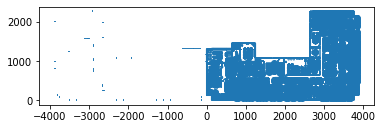

In [ ]:
floorplan_gdf.plot()

### Let's see how many unique geometry types we have

In [ ]:
# get the unique geometry types
geometry_types = floorplan_gdf.geometry.type.unique()

print(geometry_types)

['LineString' 'MultiLineString' 'GeometryCollection' 'Point']


### Create multiple gdf's for each geometry type

In [ ]:
gdf_list = []

# create a new GeoDataFrame for each geometry type
for geometry_type in geometry_types:
    gdf_list.append(floorplan_gdf[floorplan_gdf.geometry.type == geometry_type].copy())

### Preview them

<Axes: >

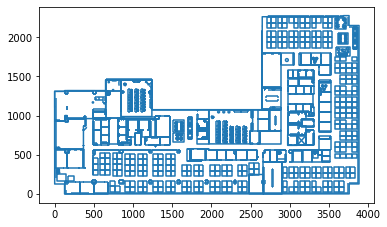

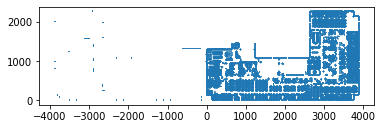

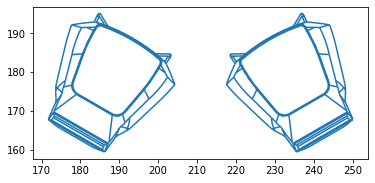

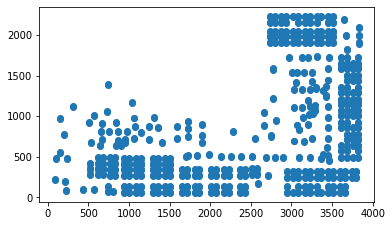

In [ ]:
gdf_list[0].plot()
gdf_list[1].plot()
gdf_list[2].plot()
gdf_list[3].plot()

### Let's just keep the linestring and points gdf's

In [ ]:
linestring_gdf = gdf_list[0]
point_gdf = gdf_list[3]



---



---


## Let's get our control points (we'll use 5)

In order to get control points we need to map out how our local X, Y coordinates relate to actual longitude and latitude on the earth's surface
<br><br>
*Note latitude and longitude are not linear / planar. 
<br><br>
From wikipedia: "Although latitude and longitude form a coordinate tuple like a cartesian coordinate system, the geographic coordinate system is not cartesian because the measurements are angles and are not on a planar surface"
<br><br>
We're going to cheat and treat lat, lon as linear because our area of interest is so small. As that area becomes larger, we'd expect more distortion. In those cases, we'd want to use the appropriate cartesian coordinate system (i.e. UTM), instead of lat lon. 


---



---



In [ ]:
import pandas as pd

#define the control points
data = [
    {'X': 2648, 'Y': 2260, 'Lat': 38.90334414, 'Lon': -77.04248049},
    {'X': 2645, 'Y': 1075, 'Lat': 38.90333969, 'Lon': -77.04216144},
    {'X': 0, 'Y': 1309, 'Lat': 38.90275828, 'Lon': -77.0422264},
    {'X': 649, 'Y': 1453, 'Lat': 38.90288602, 'Lon': -77.04226273},
    {'X': 3883, 'Y': 127, 'Lat': 38.9036031, 'Lon': -77.04189755},
    {'X': 1240, 'Y': 1075, 'Lat': 38.90301213, 'Lon': -77.04215566}
]

#create a df from the data
control_df = pd.DataFrame(data)

## We're going to do 2 linear regressions 
### First one will map our local x to latitude
### Second one will map local y to longitude

### First we'll "train" our 2 models

In [ ]:
import numpy as np

#define our 2 arrays for our input and response variables
x_array = np.array(control_df.X)
lat_array = np.array(control_df.Lat)

#create variables for slope and y intercept 
m_x, b_x = np.polyfit(x_array, lat_array, 1)

print("slope: ", m_x)
print("y-intercept: ", b_x)

from sklearn.metrics import r2_score

#calculate predicted values of y using the linear regression
lat_pred = m_x*x_array + b_x

#calculate R-squared 
r_squared_x = r2_score(lat_array, lat_pred)

#print out  R-squared 
print("R-squared: ", r_squared_x)



#do the same thing for y

y_array = np.array(control_df.Y)
lon_array = np.array(control_df.Lon)

m_y, b_y = np.polyfit(y_array, lon_array, 1)

print("slope: ", m_y)
print("y-intercept: ", b_y)

from sklearn.metrics import r2_score


lon_pred = m_y*y_array + b_y


r_squared_y = r2_score(lon_array, lon_pred)


print("R-squared: ", r_squared_y)

slope:  2.211691186525369e-07
y-intercept:  38.90274935395035
R-squared:  0.9992396097315736
slope:  -2.735711952611875e-07
y-intercept:  -77.0418645789743
R-squared:  0.9997773262301302


## Now we'll run the model for our x and y points

In [ ]:
from shapely.geometry import Point

point_gdf.geometry = point_gdf.geometry.apply(lambda geometry: Point(m_x * geometry.x + b_x, m_y * geometry.y + b_y))

### Let's preview the results

<Axes: >

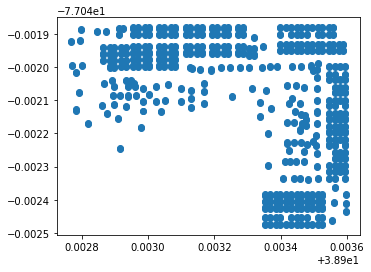

In [ ]:
point_gdf.plot()

### The original CAD file is not North-oriented -- or in other words, up does not equal north. So we are going to swap the lat and lon values (we could have done this earlier before finding the control points)

In [ ]:
point_gdf.geometry = point_gdf.geometry.apply(lambda geometry: Point(geometry.y, geometry.x))

<Axes: >

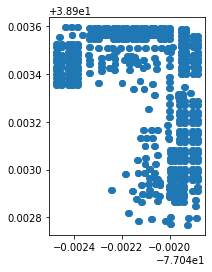

In [ ]:
point_gdf.plot()

### Let's output to GeoJSON

In [ ]:
point_gdf.to_file("points_floorplan.geojson", driver='GeoJSON')

## Let's georeference our LineString gdf, plot it, and output to GeoJSON

In [ ]:
from shapely.geometry import LineString

linestring_gdf['geometry'] = linestring_gdf['geometry'].apply(lambda geometry: LineString([(m_x * point[0] + b_x, m_y * point[1] + b_y) for point in geometry.coords]))

#swapping x and y
linestring_gdf['geometry'] = linestring_gdf['geometry'].apply(lambda geometry: LineString([(point[1], point[0]) for point in geometry.coords]))

<Axes: >

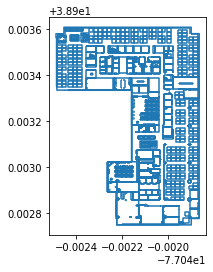

In [ ]:
linestring_gdf.plot()

In [ ]:
linestring_gdf.to_file("linestring_floorplan.geojson", driver='GeoJSON')